In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [7]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_231/func_0/'

In [8]:
closed_loop_h5_file = os.path.join(func_path, 'visual', '20220824_142240.h5')
f = h5py.File(closed_loop_h5_file, 'r')
start_thetas = f.attrs['start_theta']

In [11]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers


####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
    fictrac[short] = np.roll(fictrac[short],400) # misalignment is corrected
fictrac_timestamps = np.arange(0,expt_len,resolution)

fictrac['h'] = np.rad2deg(fictrac['h']) # radians to degree

###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

pre_window = 200
post_window = 2000

behavior_traces = {}
mean_trace = {}
sem_trace = {}
#for angle in [0,180]:
for behavior in ['Z', 'h', 'Y']:
    behavior_traces_,mean_trace,sem_trace = extract_traces(fictrac,
                                                          stimulus_start_times,
                                                          pre_window,
                                                          post_window,
                                                          behavior)
    behavior_traces[behavior] = behavior_traces_

loading photodiode data... done


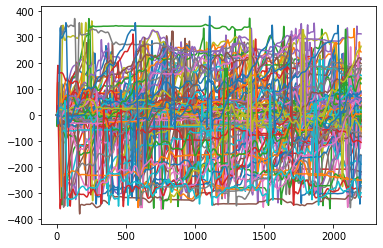

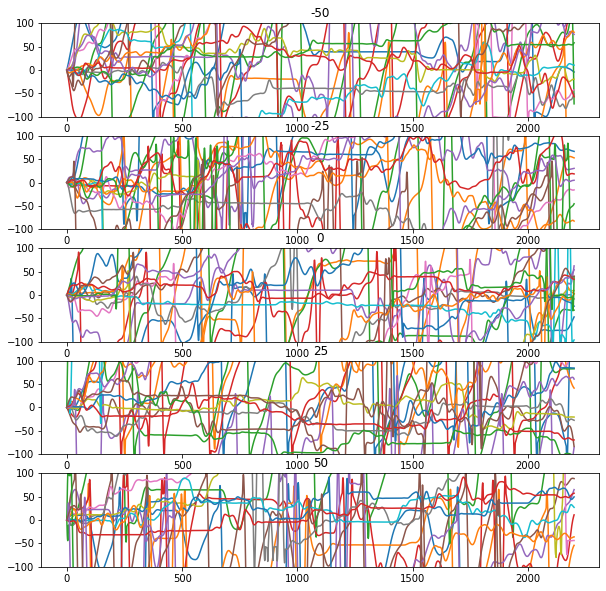

In [12]:
################################################
### Understanding of the direction of angels ###
################################################
# negative Z means right turn
# right turn caused decrease
# So, negative heading means the fly is turning to right
# for flystim, negative bar is to the left
# So, if a negative bar, we would expect positive heading

### The heading of the fly ###
behavior_traces_zero_start = []
for trace in behavior_traces['h']:
    behavior_traces_zero_start.append(trace-trace[0])# the delta of heading after the bar shows up
behavior_traces_zero_start = np.asarray(behavior_traces_zero_start)
behavior_traces['h_zero'] = behavior_traces_zero_start

### The delta heading of fly ###
for trace in behavior_traces_zero_start:
    plt.plot(trace)

np.asarray(behavior_traces_zero_start)

### Clustered behavior traces ####
plt.figure(figsize=(10,10))

trial_traces = []
fwd_traces = []
ang_traces = []
trial_idss = []
for i, theta in enumerate(np.unique(start_thetas)):
    trial_ids = np.where(start_thetas[:-1] == theta)[0] #-1 to remove last trial that doesn't exist
    trial_idss.append(trial_ids)
    plt.subplot(5,1,i+1)
#     plt.plot(np.mean(behavior_traces[trial_ids,:],axis=0))
    trial_traces.append(behavior_traces['h_zero'][trial_ids,:])
    fwd_traces.append(behavior_traces['Y'][trial_ids,:])
    ang_traces.append(behavior_traces['Z'][trial_ids,:])
    
    for trial in trial_ids:
        plt.plot(behavior_traces_zero_start[trial,:])
    plt.ylim(-100,100)
    plt.title(theta)


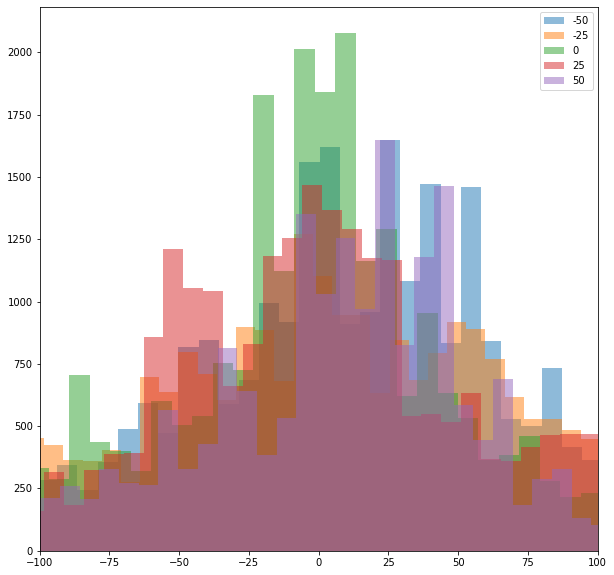

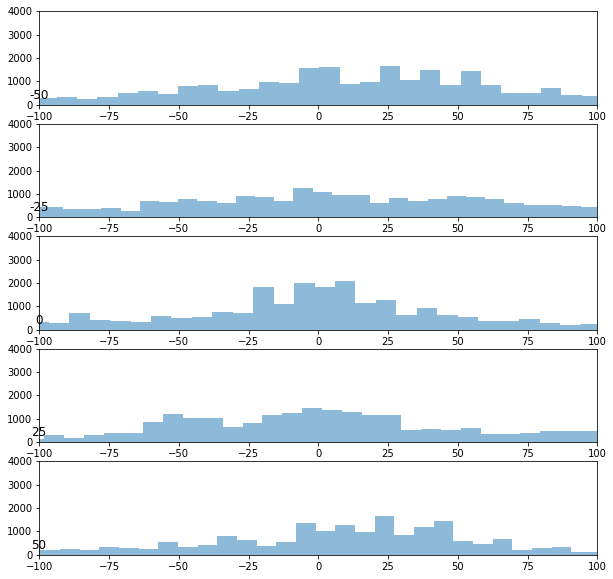

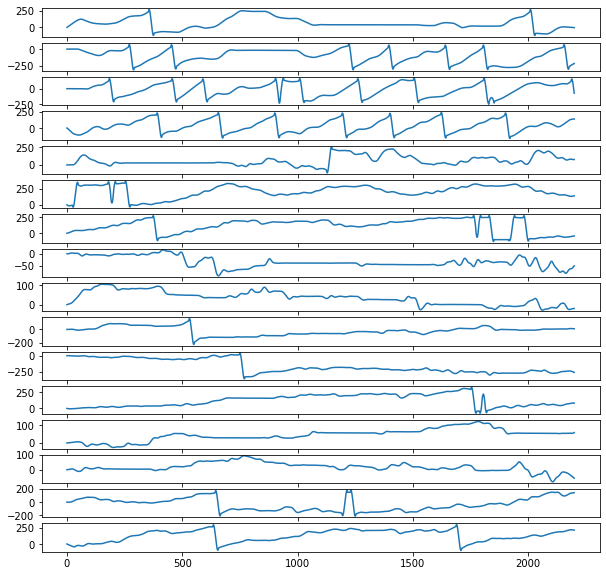

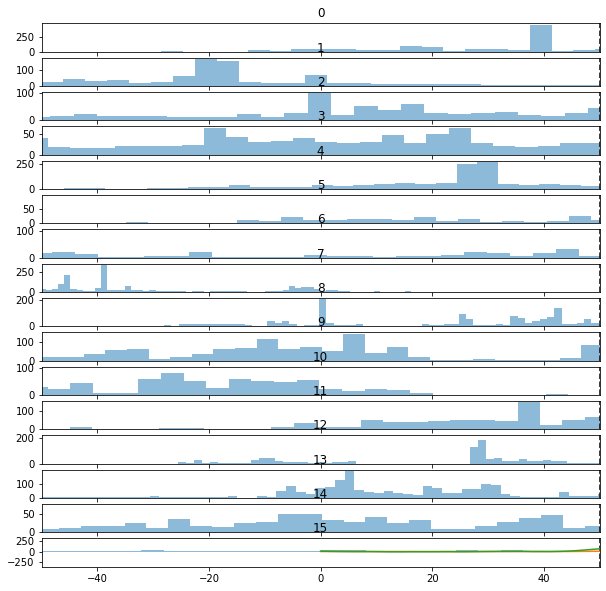

In [14]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.hist(trial_traces[i].flatten(),bins=100,alpha=.5,label=np.unique(start_thetas)[i]);
plt.xlim(-100,100)
plt.legend()

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.hist(trial_traces[i].flatten(),bins=100,alpha=.5,label=np.unique(start_thetas)[i]);
    plt.xlim(-100,100)
    plt.ylim(0,4000)
    plt.title(np.unique(start_thetas)[i],x=-.001,y=-.001)
#plt.legend()

### -50 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.plot(trial_traces[0][i])

### -50 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.hist(trial_traces[0][i,:].flatten(),bins=100,alpha=.5);
    plt.xlim(-50,50)
    plt.title(i)
    plt.axvline(50,color='k',linestyle='--')
    
plt.plot(fwd_traces[0][1,:])
plt.plot(ang_traces[0][1,:])


In [10]:
trial_idss

[]

In [8]:
trial_idsss

array([ 2,  9, 13, 16, 23, 27, 30, 38, 42, 49, 52, 59, 61, 69, 73, 76])

In [12]:
for i in range(5):
    print(i)

0
1
2
3
4


In [26]:
for i in trial_idss[0]:
    a = stimulus_start_times[i]
    print(a.item())

5730
21146
29956
36562
51979
60788
67396
85013
93823
109235
115842
131259
135664
153286
162094
168700


array(168700)